# CA5

Group 37

Group members:
* Jannicke Ådalen
* Marcus Dalaker Figenschou
* Rikke Sellevold Vegstein

In [1]:
# Standard library imports
import os

import matplotlib.pyplot as plt

# Common aliases
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn with specific imports
from sklearn import (
    ensemble as ens,
)
from sklearn import (
    impute as imp,
)
from sklearn import (
    linear_model as lm,
)
from sklearn import (
    metrics as met,
)
from sklearn import (
    model_selection as msel,
)
from sklearn import (
    pipeline as pipe,
)
from sklearn import (
    preprocessing as prep,
)
from sklearn import (
    svm as svm,
)

# Heisenbug
There is right now apparently a "Heisenbug" which only affects macs with the M4 chips that one in the group members uses. We therefore have to set numpy to ignore all warnings to prevent RuntimeWarning messages from being displayed.
https://github.com/numpy/numpy/issues/28687, due to this error we are quite limited to selecting our models.

In [2]:
np.seterr(all="ignore")

In [3]:
# Setting the styles of plots so that they have same styling throughout
sns.set_style("white")
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Set working directory
if "CA5" in os.getcwd():
    os.chdir("..")  # Go up one level if we're in CA3

print(f"Working directory now: {os.getcwd()}")

# Load data
train_path = os.path.join("CA5", "assets", "train.csv")
test_path = os.path.join("CA5", "assets", "test.csv")

# Load data
# 1. Load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Working directory now: /Users/marcusdalakerfigenschou/Documents/NMBU/DAT200


# Data inspection and cleaning

In [4]:
print("---TRAIN DATA---")
train_df.info()

print("---TEST DATA---")
test_df.info()

---TRAIN DATA---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Length (cm)                                        999 non-null    float64
 1   Width (cm)                                         999 non-null    float64
 2   Weight (g)                                         999 non-null    float64
 3   Pericarp Thickness (mm)                            998 non-null    float64
 4   Seed Count                                         999 non-null    float64
 5   Capsaicin Content                                  999 non-null    float64
 6   Vitamin C Content (mg)                             1000 non-null   float64
 7   Sugar Content                                      999 non-null    float64
 8   Moisture Content                                   1000 non-null   float

Both the test and training data er missing values, we will therefore do imputation and add values to the missing columns based on their mean values.

In [20]:
def impute_missing(df):
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    categorical_cols = df.select_dtypes(include=["object"]).columns

    # Handle missing values in numeric columns using mean imputation
    if (missing := df[numeric_cols].isnull().any()).any():
        # Create a mean imputer for numeric columns
        imputer = imp.SimpleImputer(strategy="mean")
        # Then only impute columns that actually have missing values
        df.loc[:, missing[missing].index] = imputer.fit_transform(
            df[missing[missing].index]
        )

    # Handle missing values in categorical columns using mode imputation
    if (missing := df[categorical_cols].isnull().any()).any():
        # Create a most frequent (mode) imputer for categorical columns
        imputer = imp.SimpleImputer(strategy="most_frequent")
        # Then only impute columns that actually have missing values
        df.loc[:, missing[missing].index] = imputer.fit_transform(
            df[missing[missing].index]
        )

    return df


# Apply to train and test
train_df = impute_missing(train_df)
test_df = impute_missing(test_df)

Checking

In [6]:
print("---TRAIN DATA---")
train_df.info()

print("---TEST DATA---")
test_df.info()

---TRAIN DATA---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Length (cm)                                        1000 non-null   float64
 1   Width (cm)                                         1000 non-null   float64
 2   Weight (g)                                         1000 non-null   float64
 3   Pericarp Thickness (mm)                            1000 non-null   float64
 4   Seed Count                                         1000 non-null   float64
 5   Capsaicin Content                                  1000 non-null   float64
 6   Vitamin C Content (mg)                             1000 non-null   float64
 7   Sugar Content                                      1000 non-null   float64
 8   Moisture Content                                   1000 non-null   float

The imputation has worked.

We will shorten the names of column 12 and 13 for better handling

In [7]:
train_df = train_df.rename(
    columns={"Average Daily Temperature During Growth (celcius)": "Avg Growth Temp (C)"}
)
test_df = test_df.rename(
    columns={"Average Daily Temperature During Growth (celcius)": "Avg Growth Temp (C)"}
)

# Rename the storage temperature column
train_df = train_df.rename(
    columns={"Average Temperature During Storage (celcius)": "Avg Storage Temp (C)"}
)
test_df = test_df.rename(
    columns={"Average Temperature During Storage (celcius)": "Avg Storage Temp (C)"}
)

print("---TRAIN DATA---")
train_df.info()

print("---TEST DATA---")
test_df.info()

---TRAIN DATA---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Length (cm)                1000 non-null   float64
 1   Width (cm)                 1000 non-null   float64
 2   Weight (g)                 1000 non-null   float64
 3   Pericarp Thickness (mm)    1000 non-null   float64
 4   Seed Count                 1000 non-null   float64
 5   Capsaicin Content          1000 non-null   float64
 6   Vitamin C Content (mg)     1000 non-null   float64
 7   Sugar Content              1000 non-null   float64
 8   Moisture Content           1000 non-null   float64
 9   Firmness                   1000 non-null   float64
 10  color                      1000 non-null   object 
 11  Harvest Time               1000 non-null   object 
 12  Avg Growth Temp (C)        1000 non-null   float64
 13  Avg Storage Temp (C)       1000 

## Statistical inpsection

In [8]:
print(train_df.describe())

       Length (cm)   Width (cm)   Weight (g)  Pericarp Thickness (mm)  \
count  1000.000000  1000.000000  1000.000000              1000.000000   
mean     15.574675     6.641572   169.346406                 4.619499   
std       6.264166     2.137952   123.717059                 2.826669   
min       0.300000     0.100000     0.560000                 0.000000   
25%      11.290000     5.140000    79.055000                 2.400000   
50%      15.525000     6.605000   147.515000                 4.285000   
75%      19.900000     8.042500   227.437500                 6.560000   
max      35.570000    13.620000   869.970000                14.630000   

        Seed Count  Capsaicin Content  Vitamin C Content (mg)  Sugar Content  \
count  1000.000000        1000.000000             1000.000000    1000.000000   
mean    128.731301           4.215385              142.035180       3.283534   
std      87.226676           3.161542               72.246142       1.937294   
min       0.040000    

We will drop storage temp, color and harvest time since these are object types and it will be complicated to interpret these

In [9]:
train_df = train_df.drop(
    columns=["Avg Storage Temp (C)", "color", "Harvest Time"], axis=1
)
test_df = test_df.drop(
    columns=["Avg Storage Temp (C)", "color", "Harvest Time"], axis=1
)

## Log transformation

We are dealing with regression now which is sensitive to large value ranges, we can see that we have multiple features that have large value ranges such as: seed count, vitamin c, weight and moisture. Also SHU has a large value range. We will thereofre use np.log1p which applies the log(1+x). This is to prevent it from taking log of 0 which is not possible. We must also after we have made our predictions revert back to the normal SHU scale.

In [10]:
# Transformation of features
features_to_log = [
    "Weight (g)",
    "Seed Count",
    "Moisture Content",
    "Vitamin C Content (mg)",
]

# Apply log transformation to selected features
for feature in features_to_log:
    train_df[feature] = np.log1p(train_df[feature])
    test_df[feature] = np.log1p(test_df[feature])

# Apply log transformation to SHU in training data only
train_df["Scoville Heat Units (SHU)"] = np.log1p(train_df["Scoville Heat Units (SHU)"])


print(train_df.describe())

       Length (cm)   Width (cm)   Weight (g)  Pericarp Thickness (mm)  \
count  1000.000000  1000.000000  1000.000000              1000.000000   
mean     15.574675     6.641572     4.814221                 4.619499   
std       6.264166     2.137952     0.931606                 2.826669   
min       0.300000     0.100000     0.444686                 0.000000   
25%      11.290000     5.140000     4.382714                 2.400000   
50%      15.525000     6.605000     5.000684                 4.285000   
75%      19.900000     8.042500     5.431262                 6.560000   
max      35.570000    13.620000     6.769608                14.630000   

        Seed Count  Capsaicin Content  Vitamin C Content (mg)  Sugar Content  \
count  1000.000000        1000.000000             1000.000000    1000.000000   
mean      4.511940           4.215385                4.757169       3.283534   
std       1.027543           3.161542                0.782561       1.937294   
min       0.039221    

## Labelling

We will add labels to SHU based on spicyness here for easier plotting and interpretation

In [11]:
bins = [
    0,  # Sweet
    np.log1p(1),  # Mild
    np.log1p(5001),  # Medium
    np.log1p(15001),  # Medium-Hot
    np.log1p(100001),  # Hot
    np.log1p(350001),  # Superhot
    float("inf"),  # For anything higher (Carolina Reaper types)
]

labels = ["Sweet", "Mild", "Medium", "Medium-Hot", "Hot", "Superhot"]


train_df["spiciness_labels"] = pd.cut(
    train_df["Scoville Heat Units (SHU)"], bins=bins, labels=labels, include_lowest=True
)
print(train_df[["Scoville Heat Units (SHU)", "spiciness_labels"]].head(10))

   Scoville Heat Units (SHU) spiciness_labels
0                   0.000000            Sweet
1                   0.000000            Sweet
2                  13.030239         Superhot
3                   0.000000            Sweet
4                   0.000000            Sweet
5                   0.000000            Sweet
6                  11.164390       Medium-Hot
7                   0.000000            Sweet
8                  10.353400       Medium-Hot
9                   0.000000            Sweet


# Violinplot

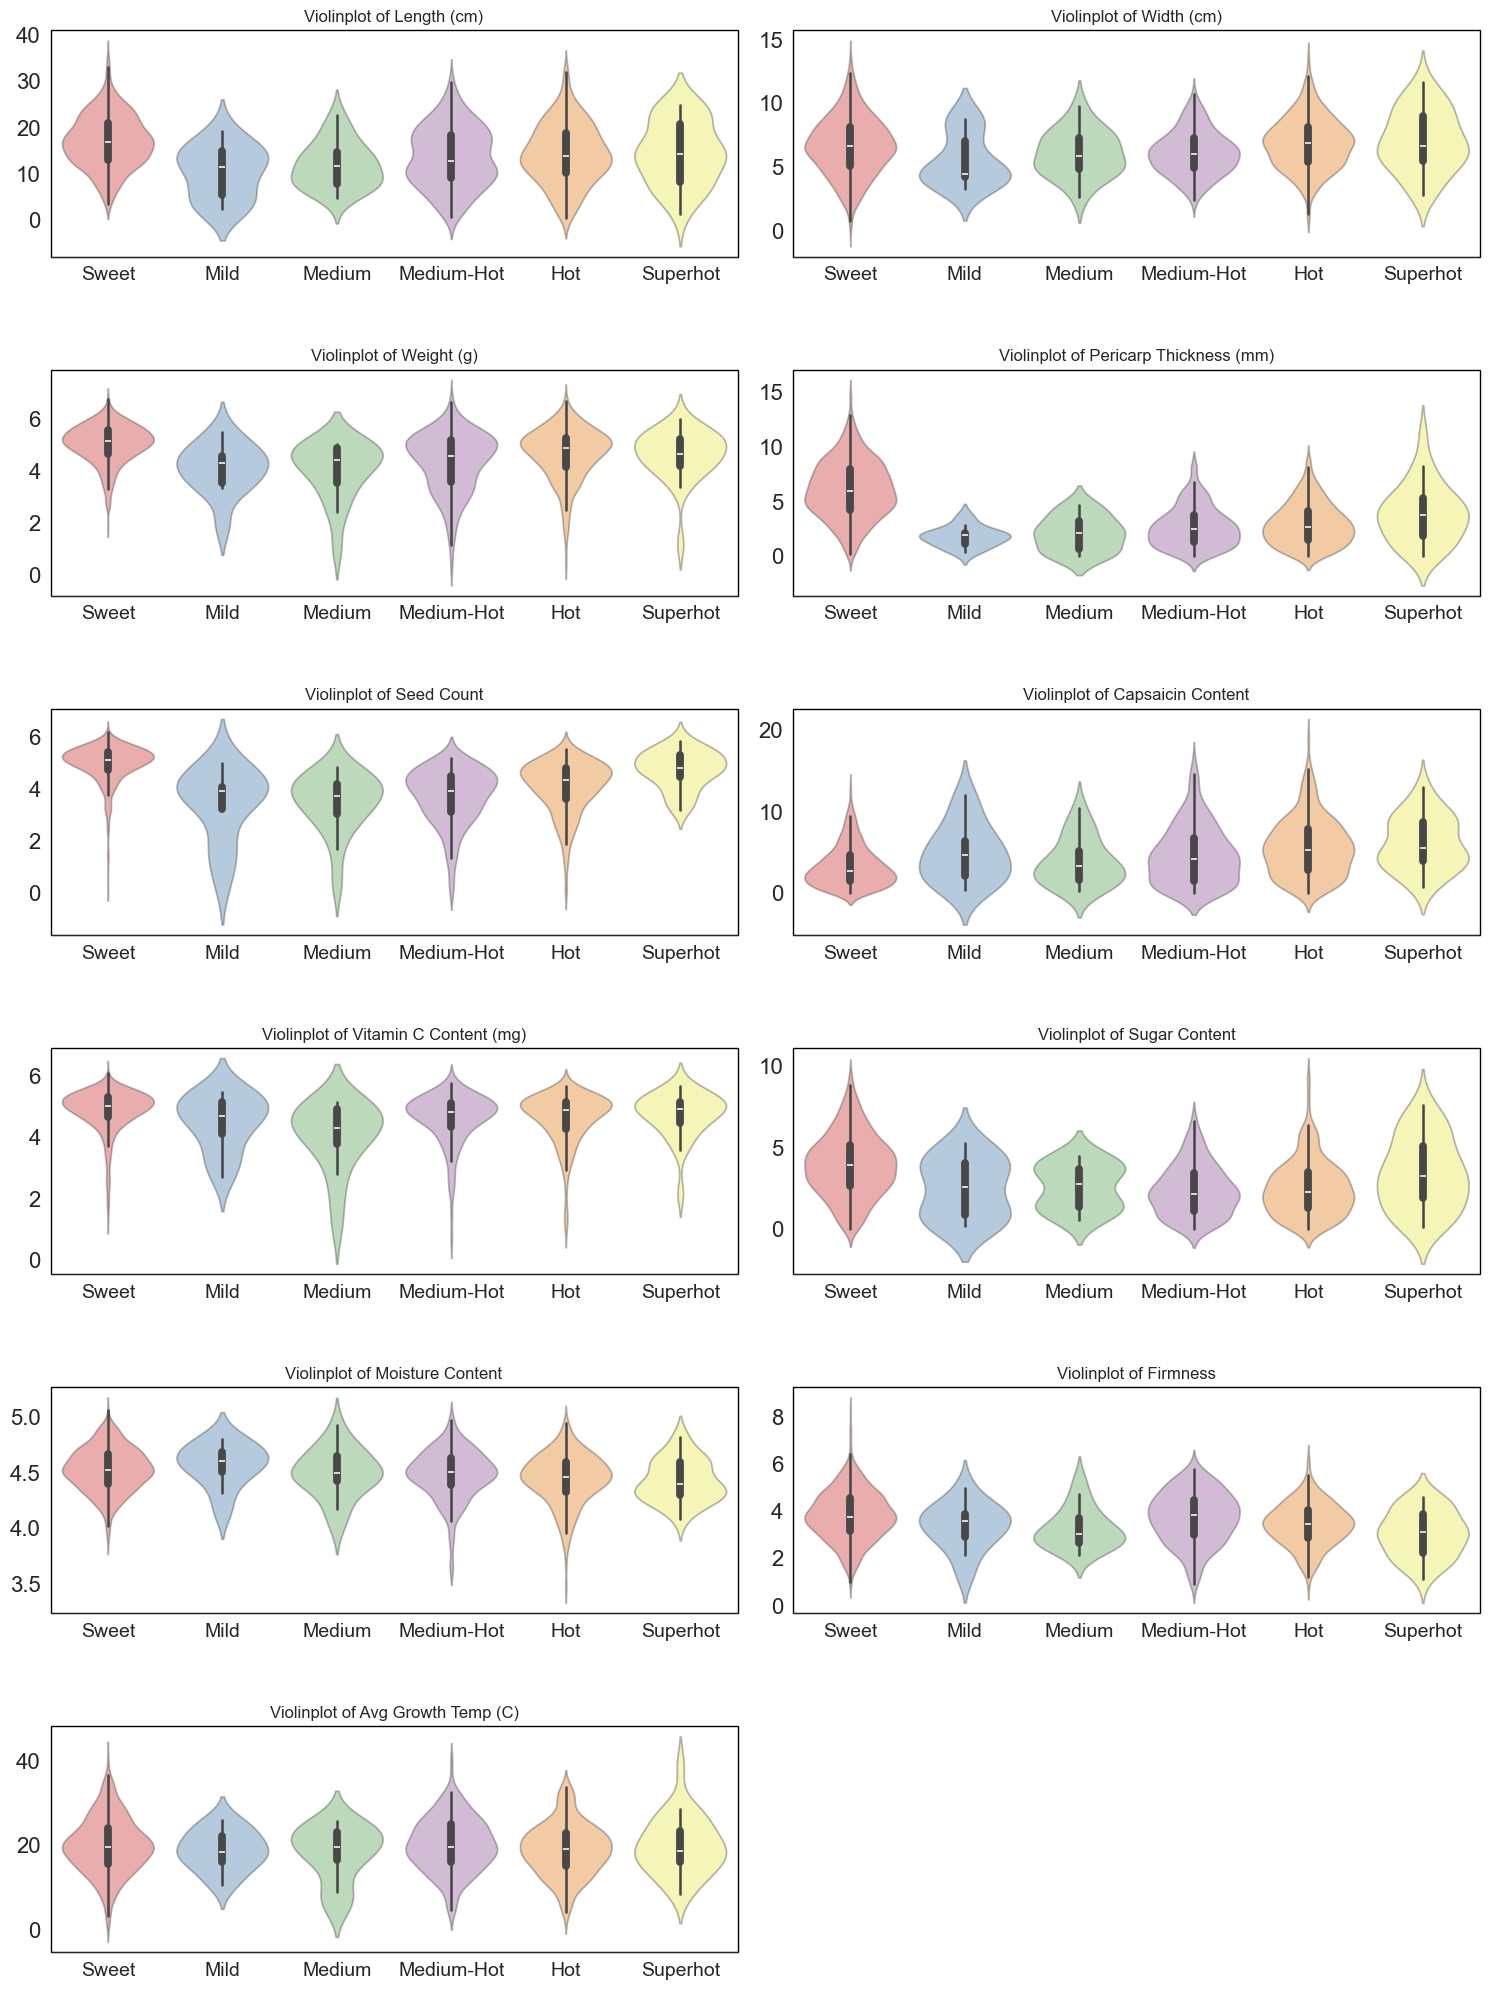

In [12]:
features = train_df.columns.drop(["spiciness_labels", "Scoville Heat Units (SHU)"])
classes = train_df["spiciness_labels"].unique()

fig, axes = plt.subplots(6, 2, figsize=(15, 20))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.violinplot(
        data=train_df,
        x="spiciness_labels",
        y=feature,
        hue="spiciness_labels",
        palette="Set1",
        ax=axes[i],
        alpha=0.4,
        orient="v",
    )
    axes[i].set_title(f"Violinplot of {feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis="x", labelsize=14)
    axes[i].patch.set_edgecolor("black")
    axes[i].patch.set_linewidth(1)
# Adjust layout
fig.delaxes(axes[11])
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.show()

Most of the features have a unimodal distribtuion, so we can safely use standardscaler here. Looking at mild pepeprs, this is the feature that is themost skewed , this is most likely just due to the range we have chosen. We can see here that there are very few features that shows clear separation between the classes, such as pericarp thickness, capsaicin content, sugar content and seed count. We will therefore expect that these are our most important features. 

## Correlation Matrix

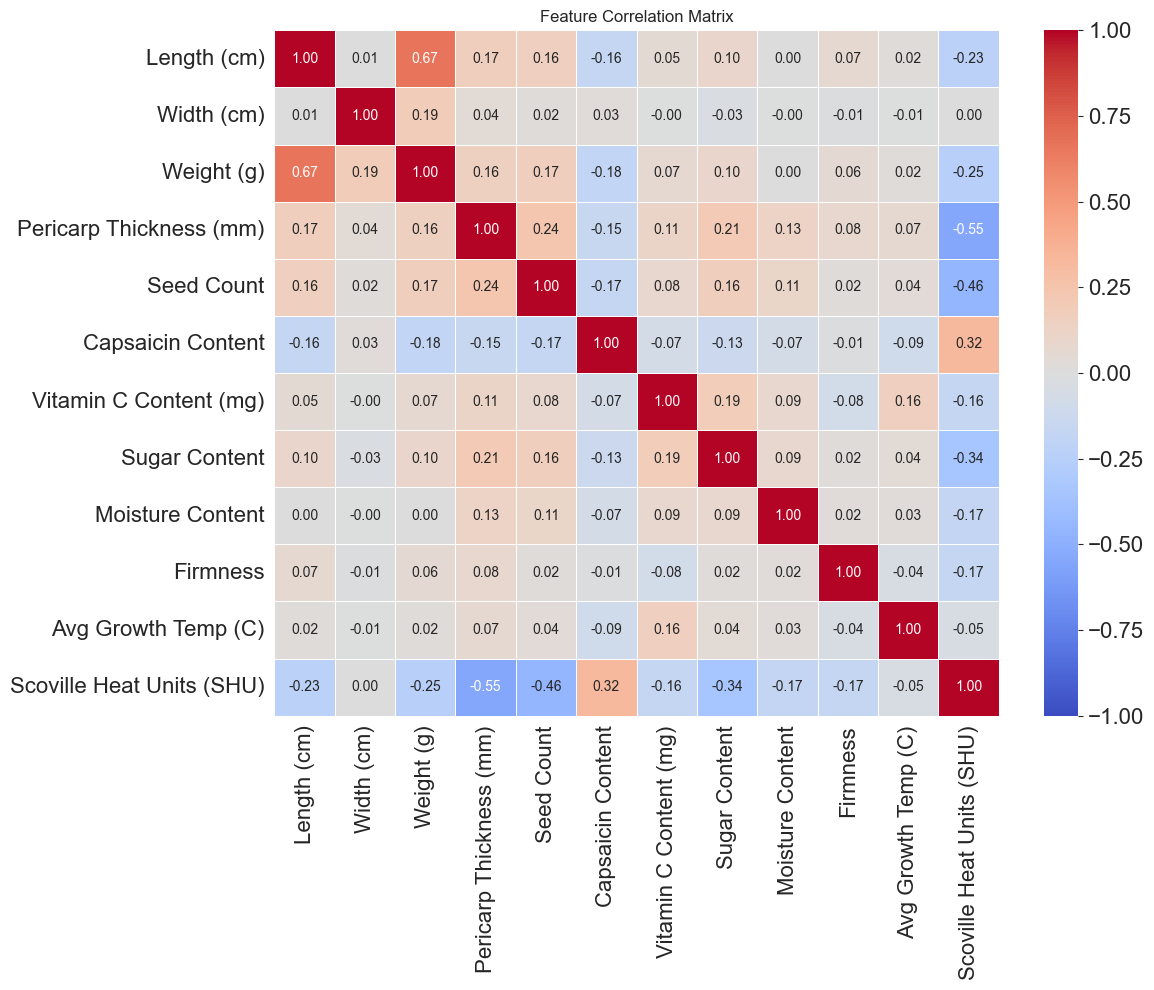

In [13]:
# Define your features (excluding target and derived variables)
features = train_df.columns.drop(["spiciness_labels"])

# Create correlation matrix for the entire dataset
correlation_matrix = train_df[features].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

We can see here that most of the features exccept of width and avg growth temp have importance towards describing Scoville heat units. The most important features are pericarp thickness, seed count, capsaicin content and sugar content. This makes sense, the less seeds the more spicy the pepper is, more sugar equals spicier pepper and more capsaicin the spicier the pepper. Our corr matrix confirms the most important features, that we guessed from the violinplot.

# Regression Models
We'll implement a regression model to predict Scoville Heat Units (SHU).

In [14]:
X = train_df.drop(columns=["Scoville Heat Units (SHU)", "spiciness_labels"])
y = train_df["Scoville Heat Units (SHU)"]

In [15]:
X_train, X_test, y_train, y_test = msel.train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Ridge

In [16]:
ridge_pipe = pipe.Pipeline(
    [
        ("scaler", prep.StandardScaler()),
        # This doesnt work with l1 and l2 because of the Heisenbug
        ("ridge", lm.Ridge(alpha=1, solver="auto")),
    ]
)

# Capture warnings during model fitting

ridge_pipe.fit(X_train, y_train)

y_pred_ridge = ridge_pipe.predict(X_test)

mae = met.mean_absolute_error(y_test, y_pred_ridge)
r2 = met.r2_score(y_test, y_pred_ridge)
print(f"Ridge - MAE: {mae:.4f}, R²: {r2:.4f}")

Ridge - MAE: 3.2518, R²: 0.5386


## Linear Regression Pipe

In [17]:
lm_pipe = pipe.Pipeline(
    [("scaler", prep.StandardScaler()), ("linear_regression", lm.LinearRegression())]
)

# Capture warnings during model fitting

lm_pipe.fit(X_train, y_train)

y_pred_lm = lm_pipe.predict(X_test)
mae = met.mean_absolute_error(y_test, y_pred_lm)
r2 = met.r2_score(y_test, y_pred_lm)
print(f"PCR - MAE: {mae:.4f}, R²: {r2:.4f}")

PCR - MAE: 3.2514, R²: 0.5386


## Gradient Boosting Pipe

In [19]:
gbr_pipe = pipe.Pipeline(
    [("scaler", prep.StandardScaler()), ("gbr", ens.GradientBoostingRegressor())]
)

# Define parameter grid for Grid Search
# Define wider parameter distributions for random search
param_grid = {
    "gbr__n_estimators": np.array([50, 100, 150, 200, 250]),
    # Generates log spaced valeus for learning rate [0.001, 0.01, 0.1, 1.0]
    "gbr__learning_rate": np.logspace(-3, 0, 4),
    "gbr__max_depth": np.array([3, 6, 9]),
    "gbr__min_samples_split": np.array([2, 8, 16]),
    "gbr__subsample": np.array([0.7, 0.85, 1.0]),
}


# Creating gridsearch
random_search = msel.GridSearchCV(
    estimator=gbr_pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=3,
    return_train_score=True,
)

# Fit the grid search
print("Starting Grid Search...")
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("\nBest Parameters:")
print(random_search.best_params_)
print(f"Best Cross-Validation Score (Negative MAE): {random_search.best_score_:.4f}")

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred_gb = best_model.predict(X_test)
mae = met.mean_absolute_error(y_test, y_pred_gb)
r2 = met.r2_score(y_test, y_pred_gb)
print(f"\nTest Set Performance - MAE: {mae:.4f}, R²: {r2:.4f}")

Starting Grid Search...

Best Parameters:
{'gbr__learning_rate': np.float64(0.1), 'gbr__max_depth': np.int64(9), 'gbr__min_samples_split': np.int64(2), 'gbr__n_estimators': np.int64(250), 'gbr__subsample': np.float64(1.0)}
Best Cross-Validation Score (Negative MAE): -2.7372

Test Set Performance - MAE: 2.7095, R²: 0.3463


## Random Forest Regressor Pipe

In [127]:
rf_reg = ens.RandomForestRegressor(n_jobs=-1, random_state=42)

rf_pipe = pipe.Pipeline([("rf_reg", rf_reg)])


# Parameter distributions for random search
param_grid_rf_reg = {
    "rf_reg__n_estimators": [100, 200, 300, 400, 500],
    "rf_reg__max_depth": [5, 10, 15, 20, 25, None],
    "rf_reg__min_samples_split": [2, 5, 10, 15, 20],
    "rf_reg__max_features": ["sqrt", "log2", None],
    "rf_reg__criterion": ["absolute_error", "squared_error", "friedman_mse"],
}


# Using gridsearch with cv set to 3
rf_reg_search = msel.GridSearchCV(
    rf_pipe,
    param_grid=param_grid_rf_reg,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
)


rf_reg_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % rf_reg_search.best_score_)
print(rf_reg_search.best_params_)


# Print best results
print("Best parameter (CV score=%0.3f):" % rf_reg_search.best_score_)
print(rf_reg_search.best_params_)

Best parameter (CV score=-2.627):
{'rf_reg__criterion': 'absolute_error', 'rf_reg__max_depth': 5, 'rf_reg__max_features': None, 'rf_reg__min_samples_split': 2, 'rf_reg__n_estimators': 100}
Best parameter (CV score=-2.627):
{'rf_reg__criterion': 'absolute_error', 'rf_reg__max_depth': 5, 'rf_reg__max_features': None, 'rf_reg__min_samples_split': 2, 'rf_reg__n_estimators': 100}


In [128]:
# Evaluate on test set
best_rf_model = rf_reg_search.best_estimator_
y_test_pred_rf = best_rf_model.score(X_test, y_test)
print(f"Test set score with best model: {y_test_pred_rf:.3f}")
print(best_rf_model)

Test set score with best model: 0.622
Pipeline(steps=[('rf_reg',
                 RandomForestRegressor(criterion='absolute_error', max_depth=5,
                                       max_features=None, n_jobs=-1,
                                       random_state=42))])


In [143]:
# Get predictions on the sample test set
y_pred_rf = best_rf_model.predict(X_test)

print(f"MAE: {met.mean_absolute_error(y_test, y_pred_rf):.3f}")
print(f"R²: {met.r2_score(y_test, y_pred_rf):.3f}")

MAE: 2.145
R²: 0.622


The best model is the random forest regression model, which has the lowest MAE of 2.145 and the highest R^2 of 0.622.

In [130]:
X_full = train_df.drop(columns=["Scoville Heat Units (SHU)", "spiciness_labels"])
y_full = train_df["Scoville Heat Units (SHU)"]

final_rf_reg = ens.RandomForestRegressor(
    n_estimators=rf_reg_search.best_params_["rf_reg__n_estimators"],
    max_features=rf_reg_search.best_params_["rf_reg__max_features"],
    max_depth=rf_reg_search.best_params_["rf_reg__max_depth"],
    criterion=rf_reg_search.best_params_["rf_reg__criterion"],
    min_samples_split=rf_reg_search.best_params_["rf_reg__min_samples_split"],
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

# Create the final pipeline with scaling
final_rf_reg_pipeline = pipe.Pipeline([("rf_reg", final_rf_reg)])

# Train the pipeline on unscaled data - pipeline handles scaling internally
final_rf_reg_pipeline.fit(X_full, y_full)

Pipeline(steps=[('rf_reg',
                 RandomForestRegressor(criterion='absolute_error', max_depth=5,
                                       max_features=None, n_jobs=-1,
                                       random_state=42))])

In [131]:
ypred = final_rf_reg_pipeline.predict(test_df)

# Create the final dataframe with numeric class predictions
ypred = pd.DataFrame(ypred, columns=["Scoville Heat Units (SHU)"])
ypred["Scoville Heat Units (SHU)"] = np.expm1(ypred["Scoville Heat Units (SHU)"])
ypred.index.name = "index"

# Add file path with appropriate naming related to model parameters
base_dir = os.path.join("CA5", "results")
os.makedirs(base_dir, exist_ok=True)
filename = "rf_reg_model_3.csv"
file_path = os.path.join(base_dir, filename)

# Save to CSV
ypred[["Scoville Heat Units (SHU)"]].to_csv(file_path)
print(f"Saved rf submission to {file_path}")

Saved rf submission to CA5/results/rf_reg_model_3.csv


# Task C: Two-step Analysis with GradientBoosting and RandomForest

First step: Create a binary classifier to separate bell peppers (SHU=0) from spicy peppers (SHU>0)
We need to create a binary target variable first. Before that we must convert the log-transformed SHU back to original scale for creating the binary labels. We will make another column for this.


In [132]:
original_shu = np.expm1(train_df["Scoville Heat Units (SHU)"])

In [133]:
# Create binary feature 'is_spicy' where 1 indicates the pepper has SHU > 0 (spicy),
# and 0 indicates the pepper has no capsaicin (sweet/bell peppers)
train_df["is_spicy"] = (original_shu > 0).astype(int)

# Check distribution of bell vs spicy peppers
print("Distribution of pepper types:")
print(train_df["is_spicy"])

Distribution of pepper types:
0      0
1      0
2      1
3      0
4      0
      ..
995    1
996    0
997    0
998    1
999    1
Name: is_spicy, Length: 1000, dtype: int64


In [134]:
X_binary = train_df.drop(
    columns=["Scoville Heat Units (SHU)", "spiciness_labels", "is_spicy"]
)
y_binary = train_df["is_spicy"]

# Split data for binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = msel.train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Create binary classifier pipeline with GradientBoostingClassifier
binary_pipe = pipe.Pipeline(
    [
        ("scaler", prep.StandardScaler()),
        ("classifier", ens.GradientBoostingClassifier(random_state=42)),
    ]
)

# Define hyperparameter grid for tuning GradientBoostingClassifier
binary_grid = {
    # Testing different numbers of trees (50, 100, 200) to find optimal ensemble size
    "classifier__n_estimators": [50, 100, 200],
    # Testing various learning rates (0.01, 0.1, 0.5) to optimize the gradient descent step size
    "classifier__learning_rate": [0.01, 0.1, 0.5],
    # Testing different tree depths (3, 5, 7) to balance complexity and generalization
    "classifier__max_depth": [3, 5, 7],
    # Testing various split thresholds (2, 5, 10) to control node creation criteria
    "classifier__min_samples_split": [2, 5, 10],
    # Testing partial (0.8) vs full (1.0) sample usage for building each tree
    "classifier__subsample": [0.8, 1.0],
}

# Optimize binary classifier
binary_cv = msel.GridSearchCV(
    binary_pipe,
    param_grid=binary_grid,
    cv=3,
    n_jobs=-1,
    scoring="f1",  # F1 score is good for potentially imbalanced classes
    return_train_score=True,
    verbose=1,
)

# Fit binary classifier
binary_cv.fit(X_train_binary, y_train_binary)

# Print best parameters
print("Best parameters for binary classifier:", binary_cv.best_params_)
print("Best binary classification score:", binary_cv.best_score_)

# Evaluate binary classifier on test set
y_pred_binary = binary_cv.predict(X_test_binary)
print("\nBinary Classification Report:")
print(met.classification_report(y_test_binary, y_pred_binary))

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for binary classifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best binary classification score: 0.8389320801834873

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       108
           1       0.90      0.86      0.88        92

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



In [135]:
# Filter training data to only include spicy peppers for regression
spicy_indices_train = train_df["is_spicy"] == 1
X_regression = train_df[spicy_indices_train].drop(
    columns=["Scoville Heat Units (SHU)", "spiciness_labels", "is_spicy"]
)
y_regression = train_df[spicy_indices_train]["Scoville Heat Units (SHU)"]

In [136]:
print(y_regression.describe())

count    459.000000
mean      11.528942
std        1.188671
min        3.395515
25%       11.067089
50%       11.812449
75%       12.330241
max       13.176171
Name: Scoville Heat Units (SHU), dtype: float64


In [139]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = msel.train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Create regression pipeline with RandomForestRegressor
regression_pipe = pipe.Pipeline(
    [
        ("scaler", prep.StandardScaler()),
        ("regressor", ens.RandomForestRegressor(random_state=42)),
    ]
)

# Define hyperparameter grid for RandomForestRegressor
regression_grid = {
    "regressor__n_estimators": [50, 100, 200, 300],
    "regressor__max_depth": [None, 10, 20, 30],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
}

# Optimize regression model
regression_cv = msel.GridSearchCV(
    regression_pipe,
    param_grid=regression_grid,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    verbose=1,
)

# Fit regression model
regression_cv.fit(X_train_reg, y_train_reg)

# Print best parameters
print("Best parameters for regression:", regression_cv.best_params_)
print("Best regression score:", regression_cv.best_score_)

# Evaluate regression on test set
y_pred_reg = regression_cv.predict(X_test_reg)
print(f"Regression MAE: {met.mean_absolute_error(y_test_reg, y_pred_reg):.3f}")
print(f"Regression R²: {met.r2_score(y_test_reg, y_pred_reg):.3f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters for regression: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Best regression score: -0.8181580552513376
Regression MAE: 0.708
Regression R²: 0.271


In [140]:
# Train final models on the full training set
# 1. Final binary classifier with GradientBoostingClassifier
final_binary_classifier = pipe.Pipeline(
    [
        ("scaler", prep.StandardScaler()),
        (
            "classifier",
            ens.GradientBoostingClassifier(
                n_estimators=binary_cv.best_params_["classifier__n_estimators"],
                learning_rate=binary_cv.best_params_["classifier__learning_rate"],
                max_depth=binary_cv.best_params_["classifier__max_depth"],
                min_samples_split=binary_cv.best_params_[
                    "classifier__min_samples_split"
                ],
                subsample=binary_cv.best_params_["classifier__subsample"],
                random_state=42,
            ),
        ),
    ]
)
final_binary_classifier.fit(X_binary, y_binary)

# 2. Final regression model with RandomForestRegressor (trained only on spicy peppers)
final_regressor = pipe.Pipeline(
    [
        ("scaler", prep.StandardScaler()),
        (
            "regressor",
            ens.RandomForestRegressor(
                n_estimators=regression_cv.best_params_["regressor__n_estimators"],
                max_depth=regression_cv.best_params_["regressor__max_depth"],
                min_samples_split=regression_cv.best_params_[
                    "regressor__min_samples_split"
                ],
                min_samples_leaf=regression_cv.best_params_[
                    "regressor__min_samples_leaf"
                ],
                random_state=42,
            ),
        ),
    ]
)
final_regressor.fit(X_regression, y_regression)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=300, random_state=42))])

In [141]:
# Step 1: Apply binary classifier to test data
binary_predictions = final_binary_classifier.predict(test_df)

# Step 2: For samples predicted as spicy we will apply the regression model
# For samples predicted as bell peppers (0), we set SHU to 0
final_predictions = np.zeros(len(test_df))
spicy_indices_test = binary_predictions == 1

if np.any(spicy_indices_test):  # Only predict if there are any spicy peppers
    # Get regression predictions for spicy samples
    regression_predictions = final_regressor.predict(test_df[spicy_indices_test])

    # Assign regression predictions to spicy samples
    final_predictions[spicy_indices_test] = regression_predictions

# Create DataFrame for submission
submission_df = pd.DataFrame(
    {
        # Convert back from log scale
        "Scoville Heat Units (SHU)": np.expm1(final_predictions)
    }
)
submission_df.index.name = "index"

# Save submission
base_dir = os.path.join("CA5", "results")
os.makedirs(base_dir, exist_ok=True)
filename = "gradientboost_randomforest_two_step_model_2_3cv.csv"
file_path = os.path.join(base_dir, filename)

submission_df.to_csv(file_path)
print(f"Saved GradientBoost-RandomForest two-step model submission to {file_path}")

Saved GradientBoost-RandomForest two-step model submission to CA5/results/gradientboost_randomforest_two_step_model_2_3cv.csv


In [142]:
# Optional: Evaluate the complete pipeline on the test split to see performance

# For binary classification
binary_acc = met.accuracy_score(y_test_binary, binary_cv.predict(X_test_binary))
print(f"Binary Classification Accuracy: {binary_acc:.3f}")

Binary Classification Accuracy: 0.890


It was C that provided use with the best model. This makes sense since the data is skewed towards peppers that are sweet (0 SHU). So when we have seperated it so clearly by first using an ensemble model that can seperate between two binary values and then just use linear regressionIn order to get a better model we will need a larger dataset. We did earlier try with another model with several bins, but  there isnt enough data to make clear distinctions between the peppers.